# **Regression**

## Objectives

* Fit and evaluate a regression model to predict sale prices of inherited houses

## Inputs

* outputs/datasets/cleaned/HousePricesCleaned.csv
* instructions on which variables to use for data cleaning and feature engineering, found in data cleaning and feature engineering notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict house prices
* labels map
* Feature Importance Plot

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the parent of current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

---

# Load Data

In [ ]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/cleaned/HousePricesCleaned.csv") 
  )

print(df.shape)
df.head(3)

In [ ]:
df_in = (pd.read_csv("outputs/datasets/cleaned/InherittedHousePricesCleaned.csv")
)
df_in.head()

# ML Pipeline: Regressor

## Import necessary libraries

In [ ]:
from sklearn.pipeline import Pipeline

### Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

### Feature Scaling
from sklearn.preprocessing import StandardScaler

### Feature Selection
from sklearn.feature_selection import SelectFromModel

### ML algorithms 
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


## Create ML pipeline

In [ ]:
# Pipeline optimization
def PipelineOptimization(model):
  pipeline_base = Pipeline([

      ("OrdinalCategoricalEncoder",OrdinalEncoder(encoding_method='arbitrary', 
                                                  variables = [ 'BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'] ) ),
      ("power",vt.PowerTransformer(variables = ['2ndFlrSF', 'BsmtUnfSF', 'GrLivArea', 'LotFrontage', 'MasVnrArea'])),
      
      ("yj",vt.YeoJohnsonTransformer(variables = ['GarageArea', 'LotArea', 'OpenPorchSF', 'TotalBsmtSF'])),
      
      ("Winsoriser_iqr",Winsorizer(capping_method='iqr', fold=1.5, tail='both', 
                                                  variables=['BsmtUnfSF','GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 
                                                             'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1'])),      
       
      ("SmartCorrelatedSelection",SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6,selection_method="variance") ),

      ("feat_scaling", StandardScaler() ),

      ("feat_selection",  SelectFromModel(model) ),

      ("model", model ),
       
    ])

  return pipeline_base

Custom Class for hyperparameter Optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model=  PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train Test Set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df.drop(['SalePrice'], axis=1) ,
                                    df['SalePrice'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [111]:
models_quick_search = {
    "LinearRegression": LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

# From Scikit-learn Unit 6
params_quick_search = {
    "LinearRegression": {},

    "DecisionTreeRegressor": {'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
        },

    "RandomForestRegressor": {'model__n_estimators': [100,50, 140],
                             'model__max_depth': [None,4, 15],
                             'model__min_samples_split': [2,50],
                             'model__min_samples_leaf': [1,50],
                             'model__max_leaf_nodes': [None,50],
        },

    "ExtraTreesRegressor": {'model__n_estimators': [100,50,150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 50],
        'model__min_samples_leaf': [1,50],
        },

    "AdaBoostRegressor": {'model__n_estimators': [50,25,80,150],
                          'model__learning_rate':[1,0.1, 2],
                          'model__loss':['linear', 'square', 'exponential'],
        },

    "GradientBoostingRegressor": {'model__n_estimators': [100,50,140],
                                  'model__learning_rate':[0.1, 0.01, 0.001],
                                  'model__max_depth': [3,15, None],
                                  'model__min_samples_split': [2,50],
                                  'model__min_samples_leaf': [1,50],
                                  'model__max_leaf_nodes': [None,50],
        },

    "XGBRegressor": {'model__n_estimators': [30,80,200],
                    'model__max_depth': [None, 3, 15],
                    'model__learning_rate': [0.01,0.1,0.001],
                    'model__gamma': [0, 0.1],
        },
}

Do a hyperparameter optimization search using default hyperparameters

In [112]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


Check results

In [113]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__learning_rate,model__loss,model__gamma
173,GradientBoostingRegressor,0.716217,0.778201,0.813467,0.0404065,3,None,1,50,50,0.1,NaN,NaN
185,GradientBoostingRegressor,0.716217,0.778201,0.813467,0.0404065,3,50,1,50,50,0.1,NaN,NaN
189,GradientBoostingRegressor,0.705499,0.778189,0.820683,0.0496292,3,50,50,2,140,0.1,NaN,NaN
180,GradientBoostingRegressor,0.705499,0.778189,0.820683,0.0496292,3,None,50,50,140,0.1,NaN,NaN
192,GradientBoostingRegressor,0.705499,0.778189,0.820683,0.0496292,3,50,50,50,140,0.1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,XGBRegressor,-6.29518,-5.09351,-4.40052,0.640094,15,NaN,NaN,NaN,30,0.001,NaN,0.1
409,XGBRegressor,-6.29518,-5.09351,-4.40052,0.640094,15,NaN,NaN,NaN,30,0.001,NaN,0
403,XGBRegressor,-6.29518,-5.09351,-4.40052,0.640094,None,NaN,NaN,NaN,30,0.001,NaN,0
406,XGBRegressor,-6.29799,-5.09434,-4.40103,0.641062,3,NaN,NaN,NaN,30,0.001,NaN,0


### Do extensive search on most suitable model to find best hyperparameter configuration

Define model and parameters, for Extensive Search

In [116]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100,50,140],
        'model__learning_rate':[0.1, 0.01, 0.001],
        'model__max_depth': [3,15, None],
        'model__min_samples_split': [2,50],
        'model__min_samples_leaf': [1,50],
        'model__max_leaf_nodes': [None,50],
    },
}

Extensive GridSearch CV

In [117]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


Check results

In [118]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
16,GradientBoostingRegressor,0.716217,0.778201,0.813467,0.0404065,0.1,3,50,1,50,50
4,GradientBoostingRegressor,0.716217,0.778201,0.813467,0.0404065,0.1,3,None,1,50,50
23,GradientBoostingRegressor,0.705499,0.778189,0.820683,0.0496292,0.1,3,50,50,50,140
8,GradientBoostingRegressor,0.705499,0.778189,0.820683,0.0496292,0.1,3,None,50,2,140
11,GradientBoostingRegressor,0.705499,0.778189,0.820683,0.0496292,0.1,3,None,50,50,140
...,...,...,...,...,...,...,...,...,...,...,...
166,GradientBoostingRegressor,0.0348757,0.0519754,0.0629625,0.00966679,0.001,3,50,50,50,50
163,GradientBoostingRegressor,0.0348757,0.0519754,0.0629625,0.00966679,0.001,3,50,50,2,50
154,GradientBoostingRegressor,0.0348757,0.0519754,0.0629625,0.00966679,0.001,3,None,50,50,50
157,GradientBoostingRegressor,0.0307939,0.0514384,0.0599338,0.0105242,0.001,3,50,1,2,50


Check the best model

In [119]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [120]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 50}

Define the best regressor, based on search

In [121]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('power',
                 PowerTransformer(variables=['2ndFlrSF', 'BsmtUnfSF',
                                             'GrLivArea', 'LotFrontage',
                                             'MasVnrArea'])),
                ('yj',
                 YeoJohnsonTransformer(variables=['GarageArea', 'LotArea',
                                                  'OpenPorchSF',
                                                  'TotalBsmtS...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     '

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', '1stFlrSF', '2ndFlrSF', 'GarageArea']


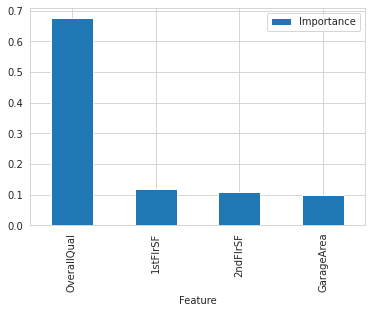

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

data_cleaning_feat_eng_steps = 5 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
          'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
          'Importance': best_regressor_pipeline['model'].feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.show()

## Evaluate on Train and Test Sets

In [123]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
import numpy as np

def regression_performance(X_train, y_train, X_test, y_test,pipeline):
	print("Model Evaluation \n")
	print("* Train Set")
	regression_evaluation(X_train,y_train,pipeline)
	print("* Test Set")
	regression_evaluation(X_test,y_test,pipeline)

def regression_evaluation(X,y,pipeline):
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.869
Mean Absolute Error: 19917.935
Mean Squared Error: 808341395.65
Root Mean Squared Error: 28431.345


* Test Set
R2 Score: 0.803
Mean Absolute Error: 22556.893
Mean Squared Error: 1361348937.56
Root Mean Squared Error: 36896.462




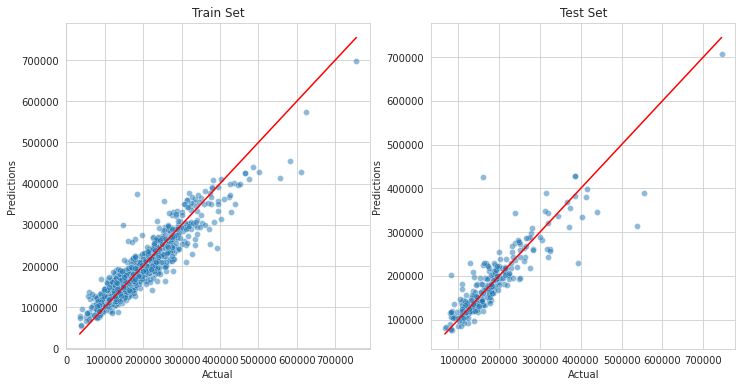

In [124]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Pipeline

* Regression

The regressor pipeline reached the expected performance threshold (0.75 R2 score) for train and test set.
The regressor with PCA didn't have accuracy gains over the regressor pipeline. So we choose the regressor pipeline.

In [125]:
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('power',
                 PowerTransformer(variables=['2ndFlrSF', 'BsmtUnfSF',
                                             'GrLivArea', 'LotFrontage',
                                             'MasVnrArea'])),
                ('yj',
                 YeoJohnsonTransformer(variables=['GarageArea', 'LotArea',
                                                  'OpenPorchSF',
                                                  'TotalBsmtS...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     '

# Refit pipeline with best features

## Rewrite Pipeline

In [132]:
def PipelineOptimization(model):
    pipeline_base = Pipeline(steps=[('power',
                 vt.PowerTransformer(variables=['2ndFlrSF'])),
                ('yj',
                 vt.YeoJohnsonTransformer(variables=['GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(min_samples_split=50,
                                           n_estimators=50, random_state=0))])
    return pipeline_base

## Split Train Test Set, only with best features

Subset Best Features

In [127]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)
X_in = df_in.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1168, 4) (1168,) 
* Test set: (292, 4) (292,)


,1stFlrSF,2ndFlrSF,GarageArea,OverallQual
618,1828,0.0,774,9
870,894,0.0,308,5
92,964,0.0,432,5


## Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

In [128]:
models_search

{'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0)}

And the best parameters from the previous GridCV search

In [129]:
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 50}

You will need to type in manually, since the hyperparameter values has to be a list. The previous dictonary is not in this format

In [149]:
params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [50,],
        'model__learning_rate':[0.1,],
        'model__max_depth': [3,],
        'model__min_samples_split': [50,],
        'model__min_samples_leaf': [1,],
        'model__max_leaf_nodes': [None,],
    }
}

GridSearch CV

In [150]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Check results

In [151]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,GradientBoostingRegressor,0.638573,0.676169,0.7122,0.0273088,0.1,3,None,1,50,50


Check the best model

In [137]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Define the best clf pipeline

In [138]:
best_pipeline_regressor = grid_search_pipelines[best_model].best_estimator_
best_pipeline_regressor

Pipeline(steps=[('power', PowerTransformer(variables=['2ndFlrSF'])),
                ('yj', YeoJohnsonTransformer(variables=['GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(min_samples_split=50,
                                           n_estimators=50, random_state=0))])

# Push files to the repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* label map
* features importance plot

In [139]:
import joblib
import os

version = 'v3'
file_path = f'outputs/ml_pipeline/predict_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set : features and target

In [ ]:
X_train.head()

In [140]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train.head()

In [141]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [ ]:
X_test.head()

In [142]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test.head()

In [143]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

In [ ]:
X_in.head()

In [144]:
X_in.to_csv(f"{file_path}/X_in.csv", index=False)

## Modelling pipeline

ML pipeline for predicting tenure

In [145]:
best_pipeline_regressor

Pipeline(steps=[('power', PowerTransformer(variables=['2ndFlrSF'])),
                ('yj', YeoJohnsonTransformer(variables=['GarageArea'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(min_samples_split=50,
                                           n_estimators=50, random_state=0))])

In [146]:
joblib.dump(value=best_pipeline_regressor, filename=f"{file_path}/regression_pipeline.pkl")

['outputs/ml_pipeline/predict_price/v3/regression_pipeline.pkl']

## Feature importance plot

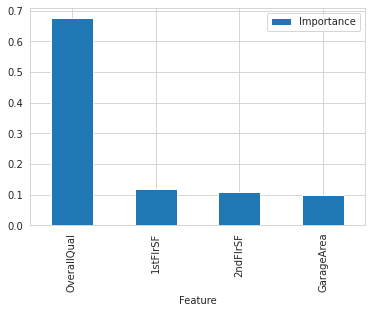

In [147]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

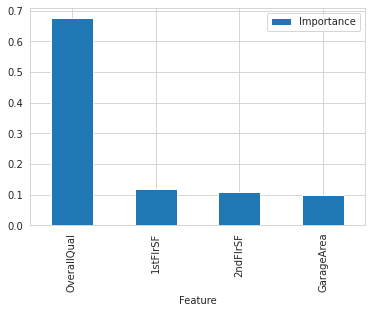

In [148]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job! Clear cell's outputs, push to the repo using git commands and move on to the next notebook

---